## Example notebook to compute eccentricity $e_{\xi}(t)$ from waveforms
This framework is developed by Islam and Venumadhav available at https://arxiv.org/abs/2502.02739

Characterizing eccentricity in gravitational waveforms in a consistent manner is crucial to facilitate parameter estimation, astrophysical population studies, as well as searches for these rare systems. 
We present a framework to characterize eccentricity directly from gravitational waveforms for non-precessing eccentric binary black hole (BBH) mergers using common modulations that eccentricity induces in all spherical harmonic modes of the signals. 
Our framework is in the spirit of existing methods that use frequency modulations in the waveforms, but we refine the approach by connecting it to state-of-the-art post-Newtonian calculations of the time evolution of the eccentricity. 
Using 39 numerical relativity (NR) simulations from the SXS and RIT catalogs, as well as waveforms obtained from the post-Newtonian approximation and effective-one-body (EOB) formalism, we show that our framework provides eccentricity estimates that connect smoothly into the relativistic regime (even up to $\sim 2M$ before merger). 
We also find that it is necessary to carry existing post-Newtonian calculations to an extra $0.5$PN order to adequately characterize existing NR simulations, and provide fits to the extra coefficient for existing simulations. 
We make the framework publicly available through the Python-based \texttt{gwModels} package. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import timeit
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# Add the path to the parent directory with the gwmodeler code
sys.path.append("../../gwModels/")
import gwModels

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
Loaded NRHybSur3dq8 model


## 1. Load waveforms

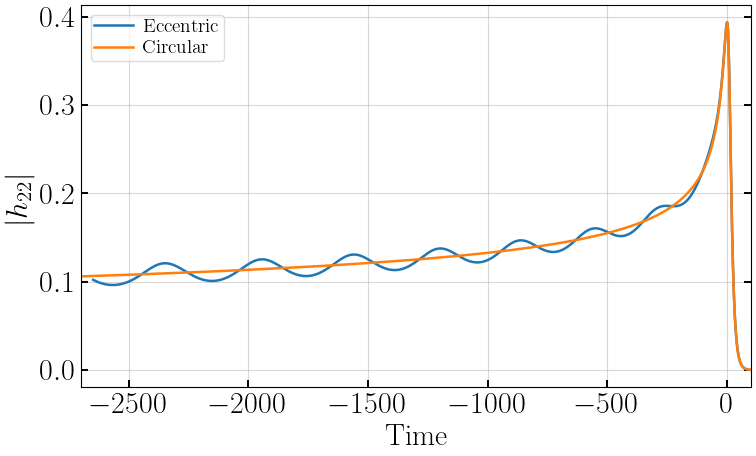

In [2]:
# load eccentric NR data from SXS:BBH:1355 and circular NR data from SXS:BBH:0180
wfs = np.load('SXSBBH1355.npy', allow_pickle=True)[()]

t_ecc = wfs['t_ecc'] 
hecc_dict = wfs['hecc_dict'] 
t_cir = wfs['t_cir'] 
hcir_dict = wfs['hcir_dict']

# plot them
plt.figure(figsize=(8,5))
plt.plot(t_ecc, abs(hecc_dict['h_l2m2']), label='Eccentric')
plt.plot(t_cir, abs(hcir_dict['h_l2m2']), label='Circular')
plt.xlim(-2700,100)
plt.xlabel('Time')
plt.ylabel('$|h_{22}|$')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

## 2. Compute eccentricity $e_{\xi}$

In [3]:
help(gwModels.ecc_measures.ComputeEccentricity)

Help on class ComputeEccentricity in module gwModels.ecc_measures.compute_ecc_xi:

class ComputeEccentricity(builtins.object)
 |  ComputeEccentricity(t_ecc=None, h_ecc_dict=None, t_cir=None, h_cir_dict=None, q=None, t_ref=None, ecc_prefactor=None, distance_btw_peaks=None, fit_funcs_orders=None, include_zero_zero=False, set_unphysical_xi_to_zero=False, set_unphysical_ecc_to_zero=True, method='xi_amp', use_xi_amp_to_get_xi_freq=False, tc=0, t_buffer=0)
 |  
 |  Class to compute eccentricity using 22 mode eccentric and circular waveform
 |  
 |  Methods defined here:
 |  
 |  __init__(self, t_ecc=None, h_ecc_dict=None, t_cir=None, h_cir_dict=None, q=None, t_ref=None, ecc_prefactor=None, distance_btw_peaks=None, fit_funcs_orders=None, include_zero_zero=False, set_unphysical_xi_to_zero=False, set_unphysical_ecc_to_zero=True, method='xi_amp', use_xi_amp_to_get_xi_freq=False, tc=0, t_buffer=0)
 |      t_ecc: time array for the eccentric 22 mode waveform
 |      h_ecc_dict: dictionary of eccen

In [4]:
# compute eccentricity
obj = gwModels.ecc_measures.ComputeEccentricity(t_ecc = t_ecc,
                                                h_ecc_dict = {'h_l2m2': hecc_dict['h_l2m2']},
                                                t_cir = t_cir,
                                                h_cir_dict = {'h_l2m2': hcir_dict['h_l2m2']},
                                                q=1, 
                                                distance_btw_peaks=2000, # choice for the distance between peak
                                                fit_funcs_orders=['3PN_m1over8', '3PN_m1over8'], # default choices for the fit orders using PN+pseudo PN expressions
                                                ecc_prefactor=2/3) # default choice for the Newtonian limit

... gwModels eccentricity at t_ref=-2638.56 : 0.07996


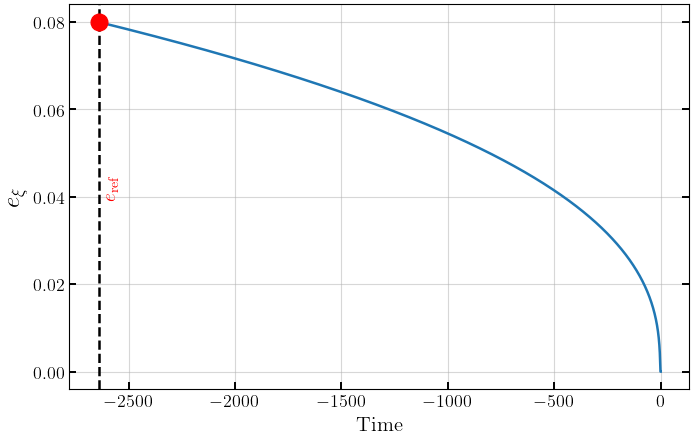

In [5]:
obj.plot_eccentricity()

## 3. Compare with gw-eccentricity package

In [6]:
import gwtools
# You need to have gw-eccentricity package from https://github.com/vijayvarma392/gw_eccentricity
from gw_eccentricity import measure_eccentricity
from gw_eccentricity import get_available_methods

In [7]:
# Setup dataDict (Note the required format)
t_common = np.linspace(min(obj.time_xi), 100, 10000)

# Setup dataDict (Note the required format)
dataDict = {"t": t_common,
           "hlm": {(2, 2): gwtools.interpolate_h(t_ecc, hecc_dict['h_l2m2'], t_common)},
           "t_zeroecc": t_common,
           "hlm_zeroecc": {(2, 2): gwtools.interpolate_h(t_cir, hcir_dict['h_l2m2'], t_common)}}

tref_in = -2350
return_dict = measure_eccentricity(tref_in=tref_in,
                                   method='ResidualAmplitude',
                                   dataDict=dataDict)
gwecc_object = return_dict["gwecc_object"]

>>> Warning: Requested samples are outside of interpolated domain.


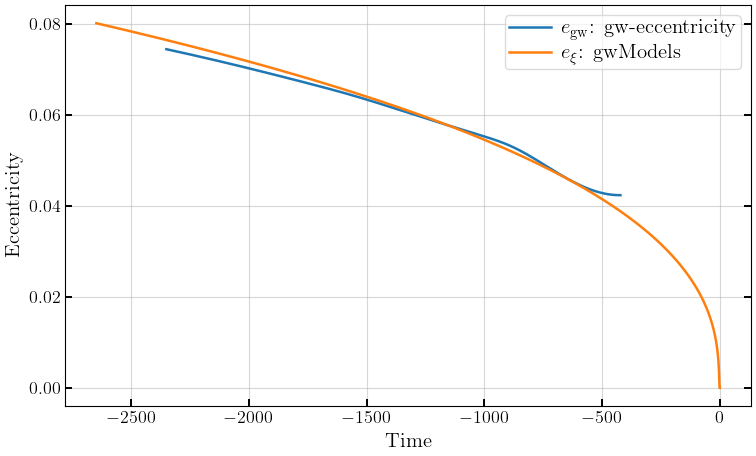

In [8]:
# comparison
plt.figure(figsize=(8,5))
plt.plot(gwecc_object.t_for_checks, gwecc_object.ecc_for_checks, label='$e_{\\rm gw}$: gw-eccentricity')
plt.plot(obj.time_xi, obj.ecc_xi, label='$e_{\\xi}$: gwModels')
plt.legend()
plt.xlabel('Time', fontsize=15)
plt.ylabel('Eccentricity', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

## 4. Diagnostic plots of all modulation parameters, fits and gwModels eccentricity

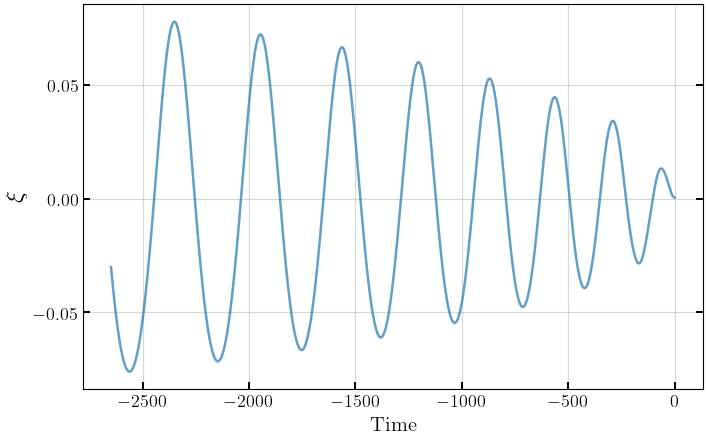

In [9]:
# plot the amplitude modulation obtained from the 22 mode
obj.plot_xi()

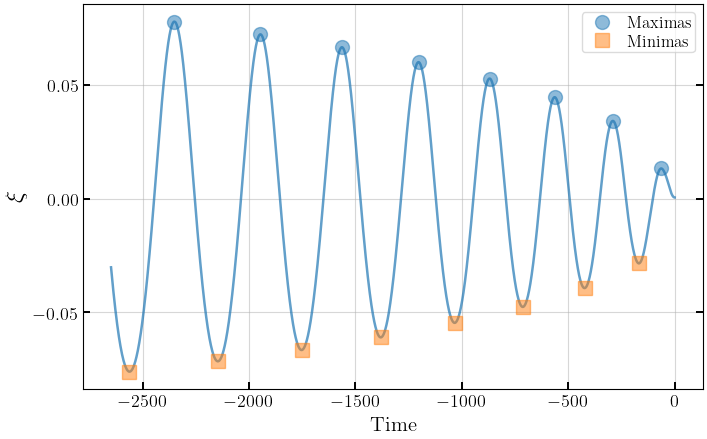

In [10]:
# find the peak of the modulation time series
obj.plot_xi_with_peaks()

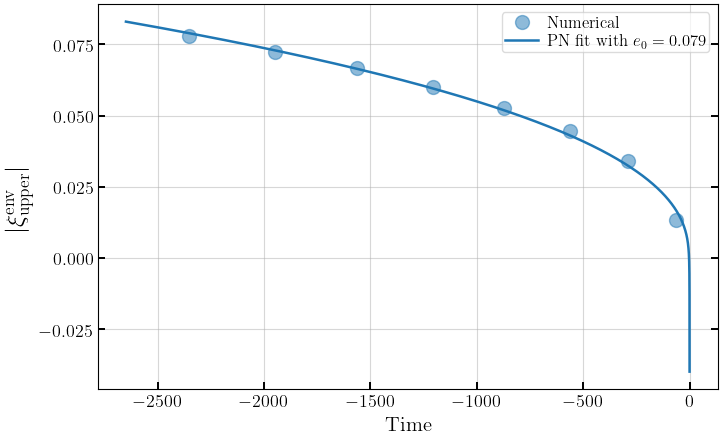

In [11]:
# fit maximas in the modulation time series
# this gives the upper envelop of the modulation xi
obj.plot_maximas_fit()

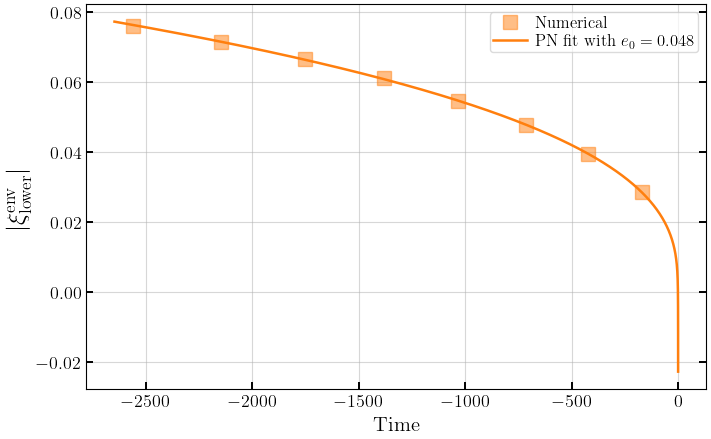

In [12]:
# fit absolute value of the minimas in the modulation time series
# this gives the lower envelop of the modulation xi
obj.plot_minimas_fit()

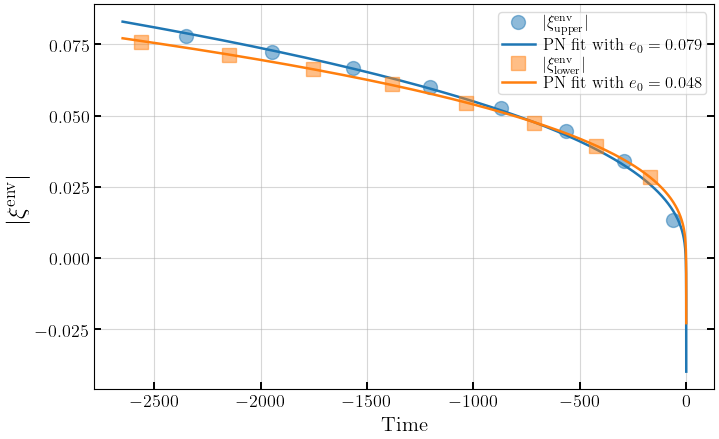

In [13]:
# show both upper and lower envelop fits together
obj.plot_maximas_and_minimas_fit()

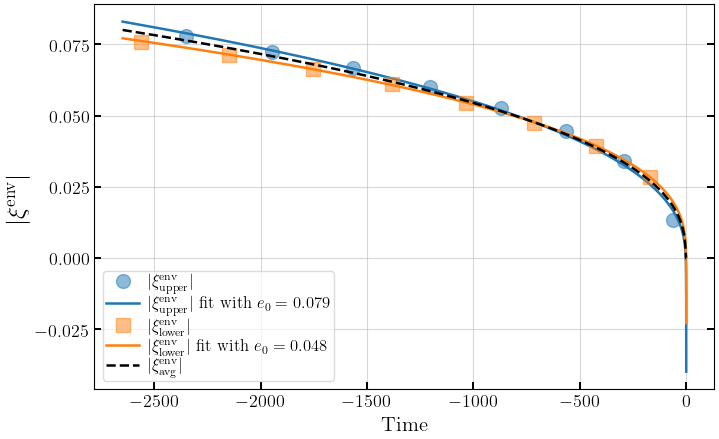

In [14]:
# obtain average envelop for the modulation params
obj.plot_maximas_minimas_and_avg_fit()

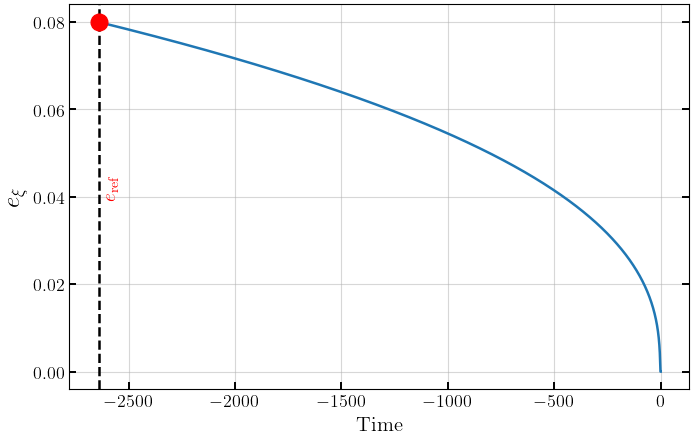

In [15]:
# obtain eccentricity from the average envelop of the modulation params and ecc pre-factor=2/3
obj.plot_eccentricity()

## 5. Calculate smooth $e_{\rm gw}$ and $e_{\omega}$ directly from gwModels using $e_{\xi}$ envelops

In [16]:
# eomega22 and egw
eobj = gwModels.ecc_measures.ComputeEccentricityFromOmega(time_xi=obj.time_xi, 
                                                          xi_lower=obj.xi_lower,
                                                          xi_upper=obj.xi_upper,
                                                          gwnrhme_obj=obj.gwnrhme_obj, 
                                                          ecc_prefactor=obj.ecc_prefactor,
                                                          t_ref=obj.t_ref)

... gwModels ecc_omega_22 at t_ref=-2638.56 : 0.05993
... gwModels ecc_gw at t_ref=-2638.56 : 0.07979


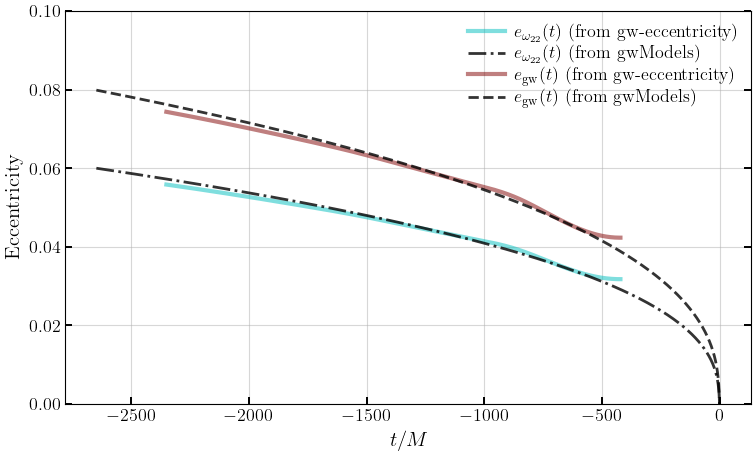

In [17]:
plt.plot(gwecc_object.t_for_checks, gwecc_object.e_omega22, c='c', ls='-', alpha=0.5, 
         label='$e_{\\omega_{22}}(t)$ (from gw-eccentricity)', lw=3)
plt.plot(obj.time_xi, eobj.ecc_omega22, c='k', alpha=0.8, lw=2, ls='-.', label='$e_{\\omega_{22}}(t)$ (from gwModels)')
plt.plot(gwecc_object.t_for_checks, gwecc_object.ecc_for_checks, c='maroon', alpha=0.5, 
         label='$e_{\\rm gw}(t)$ (from gw-eccentricity)', lw=3)
plt.plot(obj.time_xi, eobj.ecc_gw, c='k', alpha=0.8, lw=2, ls='--', label='$e_{\\rm gw}(t)$ (from gwModels)')
plt.xlabel('$t/M$', fontsize=15)
plt.ylabel('$\\rm Eccentricity$', fontsize=15)
plt.ylim(0.00,0.1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()

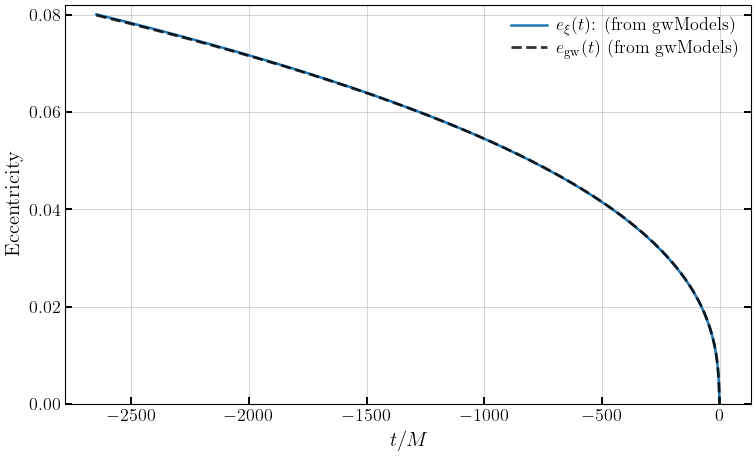

In [18]:
plt.plot(obj.time_xi, obj.ecc_xi, label='$e_{\\xi}(t)$: (from gwModels)')
plt.plot(obj.time_xi, eobj.ecc_gw, c='k', alpha=0.8, lw=2, ls='--', label='$e_{\\rm gw}(t)$ (from gwModels)')
plt.xlabel('$t/M$', fontsize=15)
plt.ylabel('$\\rm Eccentricity$', fontsize=15)
plt.ylim(0.00,0.082)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.show()